In [1]:
import pandas as pd
import sys
sys.path.append('./utils')
from utils import *
from process import * 

In [2]:
# データ保存先
data_folda = '../data/'

target_column="target3"
make_genre_list=True

In [3]:
# 説明変数のリスト
explain_columns=['prefecture_name','base_date',
       'eval_period','name','genre_first_name', 'genre_second_name','genre_third_name',
       'northlatitude', 'eastlongitude','net_reservation_flg',
       'coupons_count', 'review_count', 'hozon_count', 'all_photo_count','openning_days',
       'overview.aggregateRating', 'overview.reviewCount',
       'infos.isOfficial','infos.familiar.users.count', 
       'infos.onlineReservation', 'infos.access.transferTime1',
       'infos.wantToGo', 'infos.went', 'infos.rateByWent', 'infos.excellent', 'infos.coupon',
       'infos.photoCount.Photograph', 'infos.photoCount.Cooking',
       'infos.photoCount.Interior', 'infos.photoCount.Exterior',
       'infos.photoCount.Menu', 'infos.reviewCount.Review',
       'infos.reviewCount.Lunch', 'infos.reviewCount.Dinner',
       'menus.course_list_count',
       'menus.dishes_list_count', 'menus.lunch_list_count',
       'menus.drink_list_count', 'menus.takeout_list_count',
       'infos.aggregateRating','infos.satisfaction.percentage1',
       'infos.fanCount','infos.reviewTags.count1','infos.reviewTags.count2','infos.reviewTags.count3', 'infos.reviewTags.count4',
       'infos.reviewTags.count5', 'infos.reviewTags.count6','infos.reviewTags.count7', 'infos.reviewTags.count8','infos.reviewTags.count9']

pseudo_time_series_with = extract_features(data_folda,"train_with_master_google_retty_hotpepper.pkl",explain_columns, target_column)
#non bias dataも読み込む
pseudo_time_series_with_non_bias = extract_features(data_folda,"test_with_master_google_retty_hotpepper.pkl",explain_columns, target_column)

In [4]:
if(make_genre_list==True):
    # genreのリストを作成
    #genre0=pseudo_time_series_with["genre_first_name"].str.split(",",expand=True)[0].unique()
    #genre1=pseudo_time_series_with["genre_first_name"].str.split(",",expand=True)[1].unique()
    #genre2=pseudo_time_series_with["genre_first_name"].str.split(",",expand=True)[2].unique()
    genre0=pseudo_time_series_with["genre_first_name"].unique()
    genre1=pseudo_time_series_with["genre_second_name"].unique()
    genre2=pseudo_time_series_with["genre_third_name"].unique()
    
    genre_list = list(set(list(genre0)+list(genre1)+list(genre2)))
    #毎回読み込むのは時間がかかるので、一度読み込んだらpickleで保存しておく
    genre_list = pd.Series(genre_list)
    genre_list.dropna().to_pickle(data_folda+'genre_list.pkl')
    genre_list = pd.read_pickle(data_folda+'genre_list.pkl').dropna().to_list()
else:
    # 保存しておいたgenre_listを、listとして読み込む
    genre_list = pd.read_pickle(data_folda+'genre_list.pkl').dropna().to_list()

In [5]:
base_month_0="202304"
pseudo_time_series_with_0 = make_train_data(pseudo_time_series_with, base_month_0, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

  0%|          | 0/219 [00:00<?, ?it/s]

In [6]:
base_month_4="202307"
pseudo_time_series_with_4 = make_train_data(pseudo_time_series_with, base_month_4, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

  0%|          | 0/219 [00:00<?, ?it/s]

In [7]:
# augumented_data_train_1とaugumented_data_train_2を結合
pseudo_time_series_train=pd.concat([pseudo_time_series_with_0, pseudo_time_series_with_4])
del pseudo_time_series_with_0, pseudo_time_series_with_4


In [8]:
base_month_test="202311"
pseudo_time_series_with_test = make_train_data(pseudo_time_series_with_non_bias, base_month_test, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

  0%|          | 0/219 [00:00<?, ?it/s]

In [9]:
pseudo_time_series_train.columns.values

array(['base_date', 'eval_period', 'name', 'genre_first_name',
       'genre_second_name', 'genre_third_name', 'northlatitude',
       'eastlongitude', 'net_reservation_flg', 'coupons_count',
       'review_count', 'hozon_count', 'all_photo_count', 'openning_days',
       'overview.aggregateRating', 'overview.reviewCount',
       'infos.isOfficial', 'infos.familiar.users.count',
       'infos.onlineReservation', 'infos.access.transferTime1',
       'infos.wantToGo', 'infos.went', 'infos.rateByWent',
       'infos.excellent', 'infos.coupon', 'infos.photoCount.Photograph',
       'infos.photoCount.Cooking', 'infos.photoCount.Interior',
       'infos.photoCount.Exterior', 'infos.photoCount.Menu',
       'infos.reviewCount.Review', 'infos.reviewCount.Lunch',
       'infos.reviewCount.Dinner', 'menus.course_list_count',
       'menus.dishes_list_count', 'menus.lunch_list_count',
       'menus.drink_list_count', 'menus.takeout_list_count',
       'infos.aggregateRating', 'infos.satisfaction.

In [15]:
# lightgbmで target予測
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

to_int_list=[]
int_list=["net_reservation_flg",'overview.aggregateRating','overview.reviewCount']

drop_at_train=["base_date","eval_period"]

# テストとトレインで target 毎の平均の差が大きいものを削除
to_remove = ["name","net_reservation_flg","coupons_count","hozon_count","all_photo_count",
            'genre_first_name', 'genre_second_name','genre_third_name',
            "infos.isOfficial","infos.familiar.users.count","infos.onlineReservation","infos.coupon",
            "menus.course_list_count","menus.dishes_list_count","menus.lunch_list_count","menus.drink_list_count","menus.takeout_list_count",'infos.fanCount']

#ex = [x for x in ex if x not in to_remove]

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_train[to_int_list]=pseudo_time_series_train[to_int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_train[int_list]=pseudo_time_series_train[int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

# eval_target3が0のデータを eval_target3が1のデータの数だけランダムにサンプリング
pseudo_time_series_train_0=pseudo_time_series_train[pseudo_time_series_train[target_column]==0]
pseudo_time_series_train_1=pseudo_time_series_train[pseudo_time_series_train[target_column]==1]
pseudo_time_series_train_0=pseudo_time_series_train.sample(n=len(pseudo_time_series_train_1)*10,random_state=0)
pseudo_time_series_train_s=pd.concat([pseudo_time_series_train_0,pseudo_time_series_train_1])

# データを説明変数と目的変数に分ける
X=pseudo_time_series_train_s.drop([target_column]+drop_at_train+to_remove,axis=1)
y=pseudo_time_series_train_s[target_column]



# 学習データとテストデータに分ける
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_with_test[to_int_list]=pseudo_time_series_with_test[to_int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

pseudo_time_series_with_test[int_list]=pseudo_time_series_with_test[int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)
X_test=pseudo_time_series_with_test.drop([target_column]+drop_at_train+to_remove,axis=1)
y_test=pseudo_time_series_with_test[target_column]

# モデルの作成
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_train = lgb.Dataset(X, y)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)


# パラメータ
# クラスは2値分類で、評価指標はAUC
# クラスはバランスが取れていないので、重みを付ける
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.0001,
    'lambda_l2': 0.0001,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'class_weight': 'balanced'
}

model = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_val],
                    valid_names=['train', 'valid'],
                    num_boost_round=1000)




In [14]:
# validデータで予測・評価
y_pred = model.predict(X_val, num_iteration=model.best_iteration,predict_disable_shape_check=True)
y_pred_trans = (y_pred > 0.5).astype(int)

# 評価
accuracy = accuracy_score(y_val, y_pred_trans)
precision = precision_score(y_val, y_pred_trans)
recall = recall_score(y_val, y_pred_trans)
f1 = f1_score(y_val, y_pred_trans)
auc=roc_auc_score(y_val, y_pred)

print('Accuracy:', accuracy, "Precision:", precision, "Recall:", recall, "F1:", f1,"AUC:",auc)

Accuracy: 1.0 Precision: 1.0 Recall: 1.0 F1: 1.0 AUC: 1.0


In [16]:
# テストデータで予測・評価
y_pred = model.predict(X_test, num_iteration=model.best_iteration,predict_disable_shape_check=True)
y_pred_trans = (y_pred > 0.5).astype(int)

# 評価
accuracy = accuracy_score(y_test, y_pred_trans)
precision = precision_score(y_test, y_pred_trans)
recall = recall_score(y_test, y_pred_trans)
f1 = f1_score(y_test, y_pred_trans)
auc=roc_auc_score(y_test, y_pred)

print('Accuracy:', accuracy, "Precision:", precision, "Recall:", recall, "F1:", f1,"AUC:",auc)

Accuracy: 0.9907678379687138 Precision: 0.04890738813735692 Recall: 0.05298759864712514 F1: 0.050865800865800864 AUC: 0.6012668724891246


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

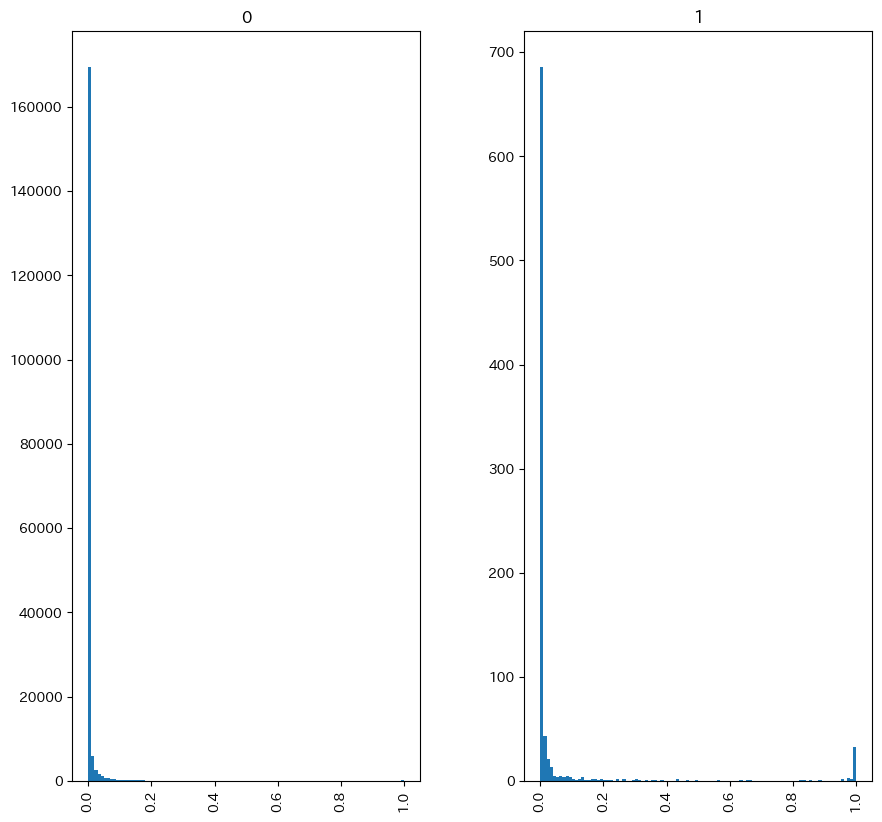

In [ ]:
# y_test, y_pred を結合して、y_test 毎に、y_pred のhistogramを作成
y_test_pred=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
y_test_pred["y_pred"].hist(by=y_test_pred["y_test"],bins=100,figsize=(10,10))

Text(0.5, 1.0, 'LightGBM Feature Importance (gain)')

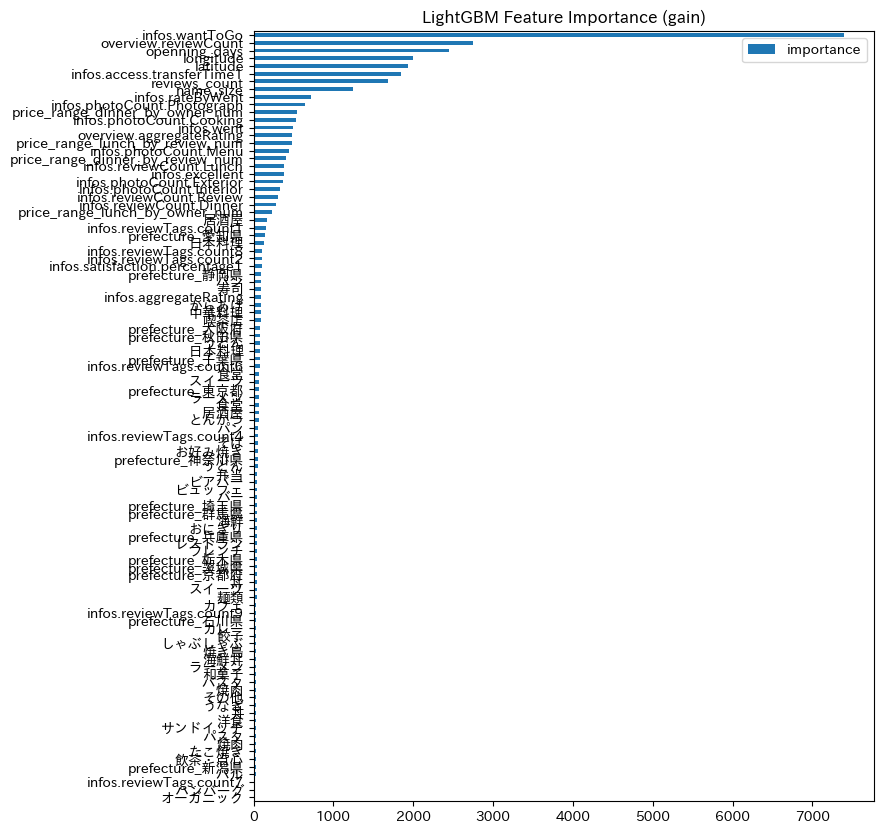

In [ ]:
# feature importance
# 日本語を表示するためにフォントを指定

importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X.columns, columns=['importance'])
importance.sort_values('importance',ascending=False).head(100).sort_values('importance').plot(kind='barh', figsize=(8, 10))
plt.title('LightGBM Feature Importance (gain)')


In [ ]:
importance

,importance
latitude,1932.073585
longitude,1993.873502
reviews_count,1682.630968
openning_days,2442.813687
price_range_lunch_by_owner_num,230.376773
...,...
prefecture_香川県,18.419035
prefecture_高知県,18.113784
prefecture_鳥取県,3.349190
prefecture_鹿児島県,0.977375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


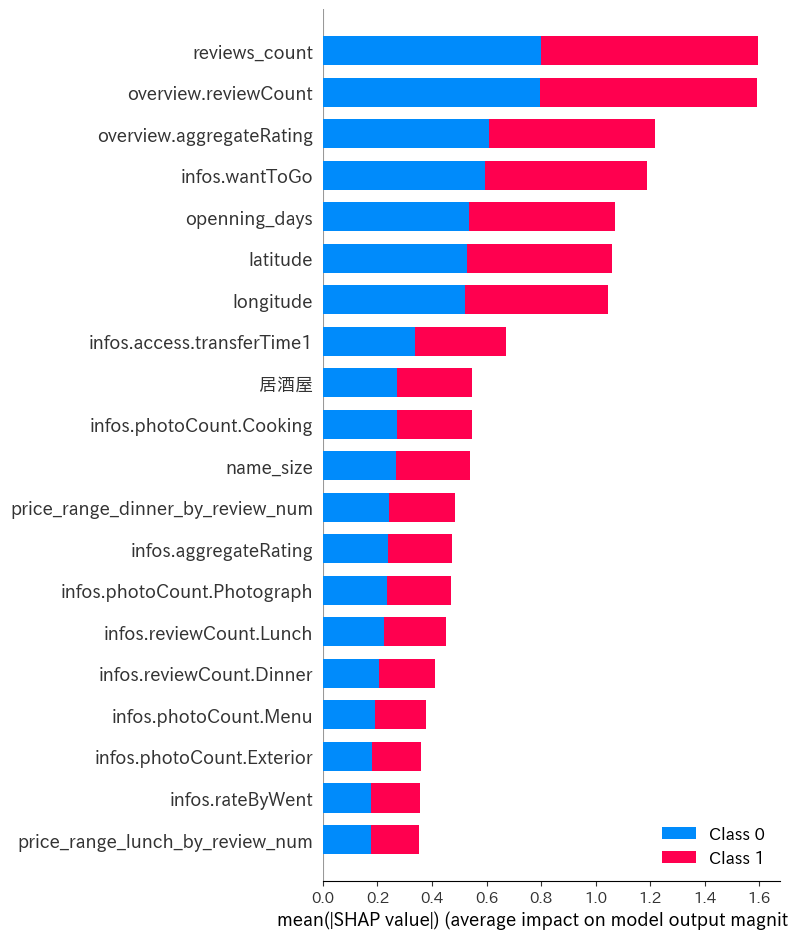

In [ ]:
# shap分析
import shap
shap.initjs()

explainer = shap.TreeExplainer(model=model)

X_test_shap = X_test.head(1000).copy().reset_index(drop=True)
shap_values = explainer.shap_values(X=X_test_shap)
# shap_values をplot
# サンプルごとのshap_valuesをplot
shap.summary_plot(shap_values, X_test_shap,max_display=20)

In [ ]:
# 1. モデル shap.Explainer()に渡す
explainer = shap.Explainer(model)

X_test_shap = X_test.head(1000)

# 2. 説明変数(特徴量)を渡す
shap_values = explainer(X_test_shap)

In [ ]:
shap.plots.waterfall(shap_values[0])

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (521, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.